# *Coffe Classifier: Thesis project for Bythem*

## Imports

In [1]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"

In [2]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_model_optimization as tfmot

from src.preprocessing import dataset_preprocessing, mixup, tensorflow_to_numpy_dataset
from src.custom_mobilenet_v2 import MobileNet_v2
from src.plotting import plot_training_history, plotting_confusion_matrix
from src.utils import get_zipped_model_size
from src.evaluation import evaluate_lite_model
from src.distiller import Distiller, WarmUpCosine

## Configurations

In [3]:
DATASET_PATH_1 = "datasets/dataset_04"
DATASET_PATH_2 = "datasets/dataset_08"
DATASET_PATH_3 = "datasets/dataset_09"


MODEL_NAME = "prova1"
DISTILLED_MODEL_NAME = "prova2"
PRUNED_MODEL_NAME = "prova3"
QUANTIZED_MODEL_NAME = "prova4"

SAVE = True

## Dataset loading and preprocessing

In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
SCALE = 127.5
OFFSET = -1

In [5]:
dataset_1 = keras.utils.image_dataset_from_directory(DATASET_PATH_1, shuffle = True, batch_size = BATCH_SIZE, image_size = (IMAGE_SIZE, IMAGE_SIZE))



class_names = dataset_1.class_names
number_classes = len(class_names)

training_dataset, validation_dataset, testing_dataset = dataset_preprocessing(dataset_1,
                                                                              train_size=0.8,
                                                                              validation_size=0.15, 
                                                                              augmentation_flag = True, 
                                                                              rescaling_flag = True, 
                                                                              prefetch_flag = True, 
                                                                              scale = SCALE, 
                                                                              offset = OFFSET)


Found 1281 files belonging to 9 classes.



In [6]:
class_names, number_classes

(['cioccolata',
  'cioccolata senza paletta',
  'errore',
  'espresso',
  'espresso senza paletta',
  'macchiato',
  'macchiato senza paletta',
  'the',
  'the senza paletta'],
 9)

In [7]:
print('Number of training images:', len(training_dataset)*BATCH_SIZE)
print('Number of validation images:', len(validation_dataset)*BATCH_SIZE)
print('Number of testing images:', len(testing_dataset)*BATCH_SIZE)

Number of training images: 1024
Number of validation images: 192
Number of testing images: 128


## **Transfer learning model**

In [8]:
DROPOUT = 0.2
FREEZING_PERCENTAGE = 1
EPOCHS = 1

Load pre-trained model

In [9]:
pre_trained_model = keras.applications.MobileNetV2(input_shape = INPUT_SHAPE, 
                                                   include_top=False, 
                                                   weights='imagenet',
                                                   alpha=0.35,
                                                   classes=number_classes)

Set weights from pre_trained model and freeze a % of the pre-trained model for transfer learning

In [10]:
model = MobileNet_v2(input_shape=INPUT_SHAPE, alpha=0.35, num_classes=number_classes, dropout=DROPOUT)

count = 0
for i, layer in enumerate(pre_trained_model.layers):
        model.layers[i].set_weights(layer.get_weights())
        count = count +1 

for i in range(int(count*FREEZING_PERCENTAGE)):
    model.layers[i].trainable= False

In [8]:
#model = MobileNet_v2(input_shape=INPUT_SHAPE, alpha=0.35, num_classes=number_classes, dropout=DROPOUT, minimization=True)

In [15]:
1280*32+32*16+16*9

41616

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 16)         432       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 16)         0         ['batch_normalization[0][0

Compile and train model

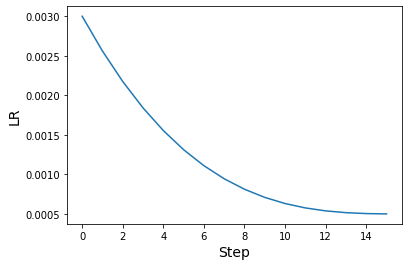

In [12]:
dataset_num_train_examples = len(training_dataset)*BATCH_SIZE
steps_per_epoch = dataset_num_train_examples // BATCH_SIZE
total_steps = steps_per_epoch * EPOCHS

learning_rate_fn = keras.optimizers.schedules.PolynomialDecay(
    3e-3,
    total_steps,
    5e-4,
    power=3)

import matplotlib.pyplot as plt
import numpy as np

lrs = learning_rate_fn(np.arange(0,total_steps))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [13]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate_fn),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=40, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(training_dataset, validation_data=validation_dataset,epochs=EPOCHS, callbacks=[early_stopping])



16/16 [==============================] - 61s 1s/step - loss: 1.7843 - accuracy: 0.2851 - val_loss: 1.4422 - val_accuracy: 0.4479


Plotting training history

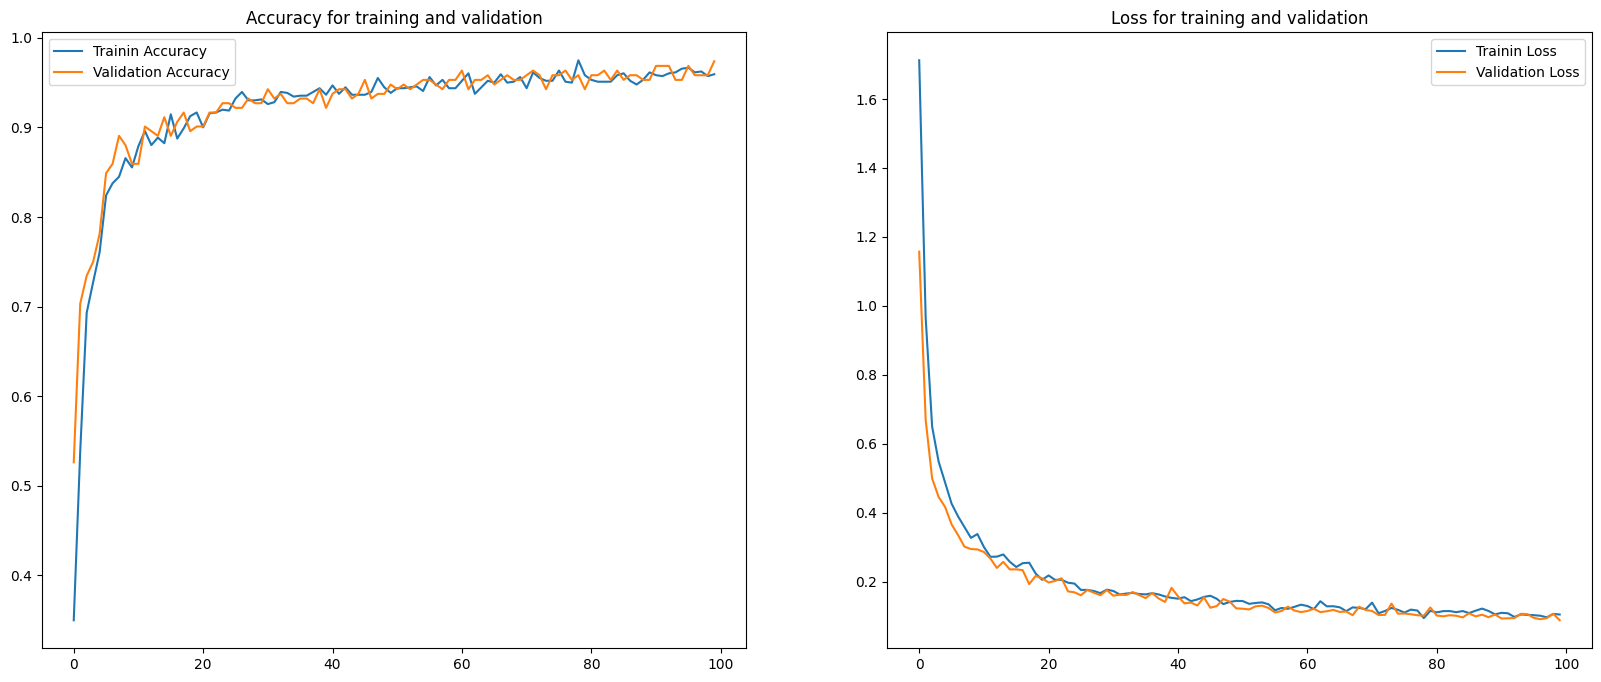

In [49]:
plot_training_history(history)

Test model

In [50]:
_, baseline_accuracy = model.evaluate(testing_dataset, verbose = 0)
print('Accuracy: ', round(baseline_accuracy*100, 3), '%')

Accuracy:  97.656 %


2024-07-12 14:52:03.080196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


4/4 [==============================] - 3s 8ms/step


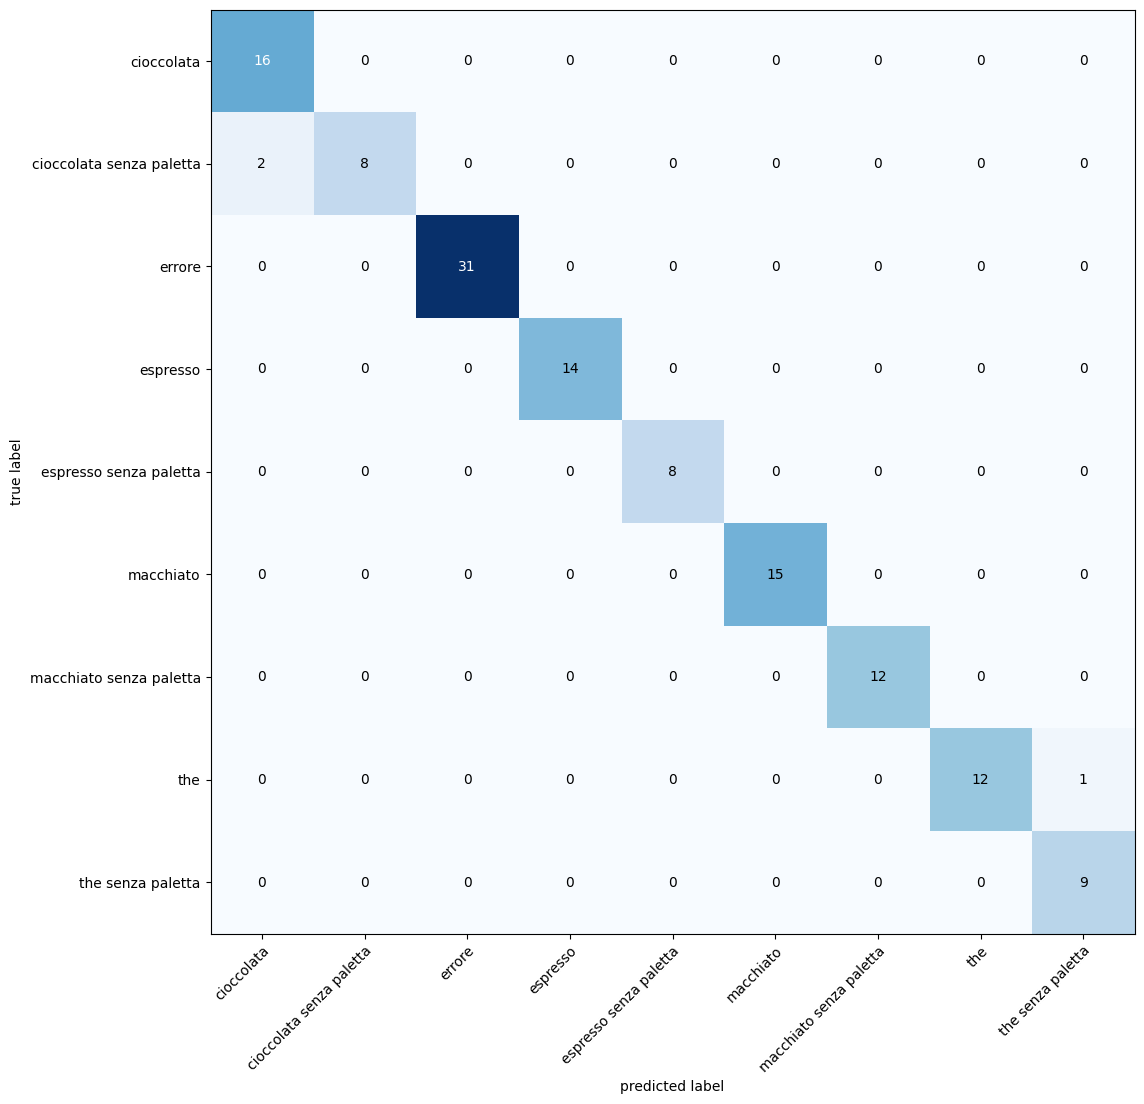

In [51]:
plotting_confusion_matrix(testing_dataset, model, class_names)

In [14]:
if SAVE:
    model.save('saved_models/' + MODEL_NAME + '.keras')
    print("Salvato")

Salvato


## **Knowladge distillation**

In [9]:
dataset_2 = keras.utils.image_dataset_from_directory(DATASET_PATH_2, shuffle = True, batch_size = BATCH_SIZE, image_size = (IMAGE_SIZE, IMAGE_SIZE))



class_names = dataset_2.class_names
number_classes = len(class_names)

training_dataset, validation_dataset, testing_dataset = dataset_preprocessing(dataset_2,
                                                                              train_size=0.9,
                                                                              validation_size=0.15, 
                                                                              augmentation_flag = True, 
                                                                              rescaling_flag = True, 
                                                                              prefetch_flag = True, 
                                                                              scale = SCALE, 
                                                                              offset = OFFSET)

print('\nNumber of training images:', len(training_dataset)*BATCH_SIZE)
print('Number of validation images:', len(validation_dataset)*BATCH_SIZE)
print('Number of testing images:', len(testing_dataset)*BATCH_SIZE)

dataset_num_train_examples = len(training_dataset)*BATCH_SIZE
steps_per_epoch = dataset_num_train_examples // BATCH_SIZE

Found 2169 files belonging to 9 classes.

Number of training images: 1920
Number of validation images: 256
Number of testing images: 0


In [8]:
DISTILLATION_EPOCHS = 5000
WARMUP_STEPS = 112500
INIT_LR = 0.003

In [10]:
total_steps = steps_per_epoch * DISTILLATION_EPOCHS
warm_up_steps = 0.75*total_steps
total_steps, warm_up_steps

(150000, 112500.0)

In [56]:
teacher_model = keras.models.load_model('saved_models/' + MODEL_NAME + '.keras')


teacher_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.KLDivergence(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

student_model = MobileNet_v2(input_shape=INPUT_SHAPE, alpha=0.35, num_classes=number_classes, dropout=DROPOUT, minimization=True)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

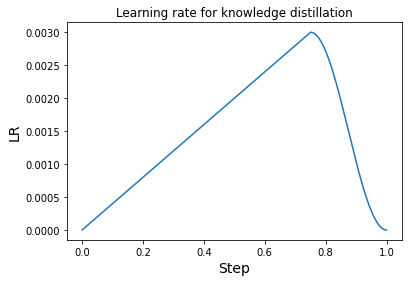

In [27]:
lr_schedule = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS,
)

lrs = lr_schedule(np.arange(0,total_steps))
plt.plot(np.arange(0,total_steps)/total_steps,lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.title("Learning rate for knowledge distillation")
plt.show()

In [58]:
mixup_training_dataset = training_dataset.map(mixup, num_parallel_calls=tf.data.AUTOTUNE)

In [59]:
WEIGTH_DECAY = 0.001
CLIP_THRESHOLD = 1.0

In [60]:
distiller = Distiller(student=student_model, teacher= teacher_model, alpha=0.1, temperature=10)

distiller.compile(
    optimizer=keras.optimizers.AdamW(weight_decay=WEIGTH_DECAY, learning_rate=lr_schedule, clipnorm=CLIP_THRESHOLD),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss = keras.losses.KLDivergence()
)

check_point = tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/' + DISTILLED_MODEL_NAME + '.keras', save_best_only=True, monitor="val_student_loss")

history = distiller.fit(mixup_training_dataset, epochs= DISTILLATION_EPOCHS, validation_data= validation_dataset)

Epoch 1/5000


/home/user/.local/lib/python3.10/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 44s 423ms/step - sparse_categorical_accuracy: 0.0878 - student_loss: 2.2487 - distillation_loss: 3.7627e-04 - val_sparse_categorical_accuracy: 0.0742 - val_student_loss: 2.2022
Epoch 2/5000
30/30 [==============================] - 2s 59ms/step - sparse_categorical_accuracy: 0.0857 - student_loss: 2.2432 - distillation_loss: 3.7883e-04 - val_sparse_categorical_accuracy: 0.0742 - val_student_loss: 2.2019
Epoch 3/5000
30/30 [==============================] - 2s 61ms/step - sparse_categorical_accuracy: 0.0873 - student_loss: 2.2344 - distillation_loss: 3.7796e-04 - val_sparse_categorical_accuracy: 0.0742 - val_student_loss: 2.2132
Epoch 4/5000
30/30 [==============================] - 2s 60ms/step - sparse_categorical_accuracy: 0.0894 - student_loss: 2.2228 - distillation_loss: 3.7199e-04 - val_sparse_categorical_accuracy: 0.0742 - val_student_loss: 2.2182
Epoch 5/5000
30/30 [==============================] - 2s 60ms/step - sparse_categorical_accurac

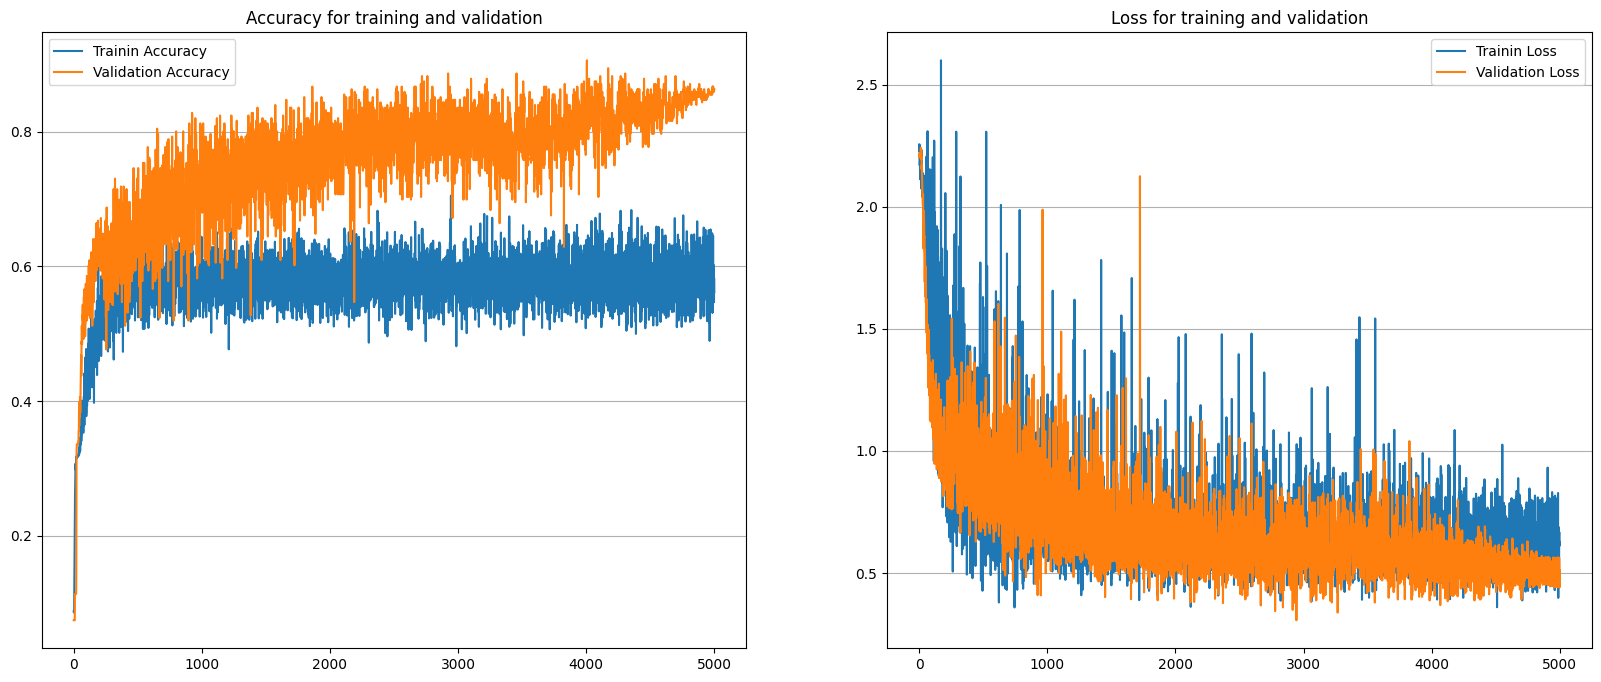

In [61]:
training_accuracy = history.history['sparse_categorical_accuracy']
validation_accuracy = history.history['val_sparse_categorical_accuracy']
training_loss = history.history['student_loss']
validation_loss = history.history['val_student_loss']

epochs_range = range(len(training_accuracy))

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, training_accuracy,   label = 'Trainin Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.grid(axis='y')
plt.legend()
plt.title('Accuracy for training and validation')

plt.subplot(1,2,2)
plt.plot(epochs_range, training_loss,   label = 'Trainin Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.grid(axis='y')
plt.legend()
plt.title('Loss for training and validation')
plt.savefig('images/test_3_distillation_training')

plt.show()

In [62]:
student_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

_, teacher_accuracy = teacher_model.evaluate(validation_dataset, verbose = 0)
_, student_accuracy = student_model.evaluate(validation_dataset, verbose = 0)
print('Teacher model accuracy: ', round(teacher_accuracy*100, 3), '%')
print('Student model accuracy: ', round(student_accuracy*100, 3), '%')

Teacher model accuracy:  68.359 %
Student model accuracy:  86.328 %


In [63]:
dataset_3 = keras.utils.image_dataset_from_directory(DATASET_PATH_3, shuffle = True, batch_size = BATCH_SIZE, image_size = (IMAGE_SIZE, IMAGE_SIZE))



class_names = dataset_3.class_names
number_classes = len(class_names)

training_dataset, validation_dataset, testing_dataset = dataset_preprocessing(dataset_3,
                                                                              train_size=0.9,
                                                                              validation_size=0.15, 
                                                                              augmentation_flag = True, 
                                                                              rescaling_flag = True, 
                                                                              prefetch_flag = True, 
                                                                              scale = SCALE, 
                                                                              offset = OFFSET)

print('\nNumber of training images:', len(training_dataset)*BATCH_SIZE)
print('Number of validation images:', len(validation_dataset)*BATCH_SIZE)
print('Number of testing images:', len(testing_dataset)*BATCH_SIZE)

Found 1072 files belonging to 9 classes.

Number of training images: 960
Number of validation images: 128
Number of testing images: 0


In [64]:
student_model.fit(training_dataset,
                 validation_data=validation_dataset,
                 epochs= 30,
                 verbose=1)

Epoch 1/30
15/15 [==============================] - 15s 62ms/step - loss: 0.4281 - sparse_categorical_accuracy: 0.9177 - val_loss: 0.3084 - val_sparse_categorical_accuracy: 0.9375
Epoch 2/30
15/15 [==============================] - 1s 37ms/step - loss: 0.2233 - sparse_categorical_accuracy: 0.9406 - val_loss: 0.1887 - val_sparse_categorical_accuracy: 0.9688
Epoch 3/30
15/15 [==============================] - 1s 37ms/step - loss: 0.1365 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.1250 - val_sparse_categorical_accuracy: 0.9688
Epoch 4/30
15/15 [==============================] - 1s 37ms/step - loss: 0.0946 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.0907 - val_sparse_categorical_accuracy: 0.9766
Epoch 5/30
15/15 [==============================] - 1s 36ms/step - loss: 0.0705 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.0836 - val_sparse_categorical_accuracy: 0.9766
Epoch 6/30
15/15 [==============================] - 1s 36ms/step - loss: 0.0560 - sparse_categorical_acc

In [65]:
_, pruned_accuracy = student_model.evaluate(validation_dataset, verbose = 0)
print('Distilled accuracy after fine-tuning: '   , round(100* pruned_accuracy,3) ,   '%')

Distilled accuracy after fine-tuning:  100.0 %


In [66]:
if SAVE:
    student_model.save('saved_models/' + DISTILLED_MODEL_NAME + '.keras')

## **Pruned Model**

In [13]:
PRUNING_EPOCHS = 3
INITIAL_SPARSITY = 0.20
FINAL_SPARSITY = 0.60
FREQUENCY = 30

In [14]:
model = keras.models.load_model('saved_models/' + MODEL_NAME + '.keras')

In [15]:
model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
model.trainable= True

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

num_images = (len(training_dataset)) *BATCH_SIZE
end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * PRUNING_EPOCHS

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=INITIAL_SPARSITY, 
                                                             final_sparsity=FINAL_SPARSITY,
                                                             begin_step=0, 
                                                             end_step=end_step,
                                                             frequency = FREQUENCY)}


pruned_model = prune_low_magnitude(model, **pruning_params)

callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

pruned_model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-5),
                     loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])


# Fine tune the model
pruned_model.fit(training_dataset,
                 validation_data=validation_dataset,
                 epochs= PRUNING_EPOCHS,
                 verbose=1,
                 callbacks=callbacks)

Epoch 1/3
16/16 [==============================] - 86s 2s/step - loss: 0.9118 - accuracy: 0.6306 - val_loss: 2.2071 - val_accuracy: 0.1198
Epoch 2/3
16/16 [==============================] - 18s 1s/step - loss: 1.0699 - accuracy: 0.5713 - val_loss: 2.2127 - val_accuracy: 0.1094
Epoch 3/3
16/16 [==============================] - 18s 1s/step - loss: 2.1120 - accuracy: 0.1956 - val_loss: 2.2268 - val_accuracy: 0.1094


In [ ]:
pruned_model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True )

pruned_model.fit(training_dataset,
                 validation_data=validation_dataset,
                 epochs=EPOCHS,
                 callbacks=[early_stopping])

Epoch 1/100
15/15 [==============================] - 32s 278ms/step - loss: 0.8927 - accuracy: 0.7740 - val_loss: 2.7325 - val_accuracy: 0.1484
Epoch 2/100
15/15 [==============================] - 1s 61ms/step - loss: 0.3747 - accuracy: 0.8677 - val_loss: 2.3346 - val_accuracy: 0.2500
Epoch 3/100
15/15 [==============================] - 1s 60ms/step - loss: 0.2037 - accuracy: 0.9260 - val_loss: 1.8724 - val_accuracy: 0.3672
Epoch 4/100
15/15 [==============================] - 1s 60ms/step - loss: 0.1070 - accuracy: 0.9698 - val_loss: 1.4186 - val_accuracy: 0.4688
Epoch 5/100
15/15 [==============================] - 1s 60ms/step - loss: 0.0805 - accuracy: 0.9802 - val_loss: 1.0956 - val_accuracy: 0.5859
Epoch 6/100
15/15 [==============================] - 1s 59ms/step - loss: 0.0610 - accuracy: 0.9885 - val_loss: 0.8728 - val_accuracy: 0.6719
Epoch 7/100
15/15 [==============================] - 1s 61ms/step - loss: 0.0396 - accuracy: 0.9937 - val_loss: 0.7230 - val_accuracy: 0.7266
Epoc

In [ ]:
_, pruned_accuracy = pruned_model.evaluate(validation_dataset, verbose = 0)
print('Pruned accuracy: '   , round(100* pruned_accuracy,3) ,   '%')

Pruned accuracy:  98.438 %


In [17]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

if SAVE:
    stripped_pruned_model.save('saved_models/' + PRUNED_MODEL_NAME + '.keras')

In [ ]:
print("Distilled model size: ", get_zipped_model_size('saved_models/' + DISTILLED_MODEL_NAME + '.keras')/10**6, ' MB')
print("Pruned model size: ", get_zipped_model_size('saved_models/' + PRUNED_MODEL_NAME + '.keras')/10**6, ' MB')

Distilled model size:  2.396358  MB
Pruned model size:  0.541202  MB


## **Quantized model**

In [18]:
model = keras.models.load_model('saved_models/' + PRUNED_MODEL_NAME + '.keras')

model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
images_batch_np, labels_batch_np = tensorflow_to_numpy_dataset(validation_dataset)

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(images_batch_np).batch(1).take(100):
    yield [input_value]


converter = tf.lite.TFLiteConverter.from_keras_model(model);
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

model_integer_quantization = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ALESSA~1\AppData\Local\Temp\tmpdbflnga1\assets


INFO:tensorflow:Assets written to: C:\Users\ALESSA~1\AppData\Local\Temp\tmpdbflnga1\assets
C:\Users\ALESSANDRO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\lite\python\convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
with open('saved_lite_models/' + QUANTIZED_MODEL_NAME + '.tflite', "wb") as f:
    f.write(model_integer_quantization)   

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Processing test dataset. Batch to process:  2 



2024-07-12 17:52:46.659310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Accuracy of compressed model model: 98.44 %


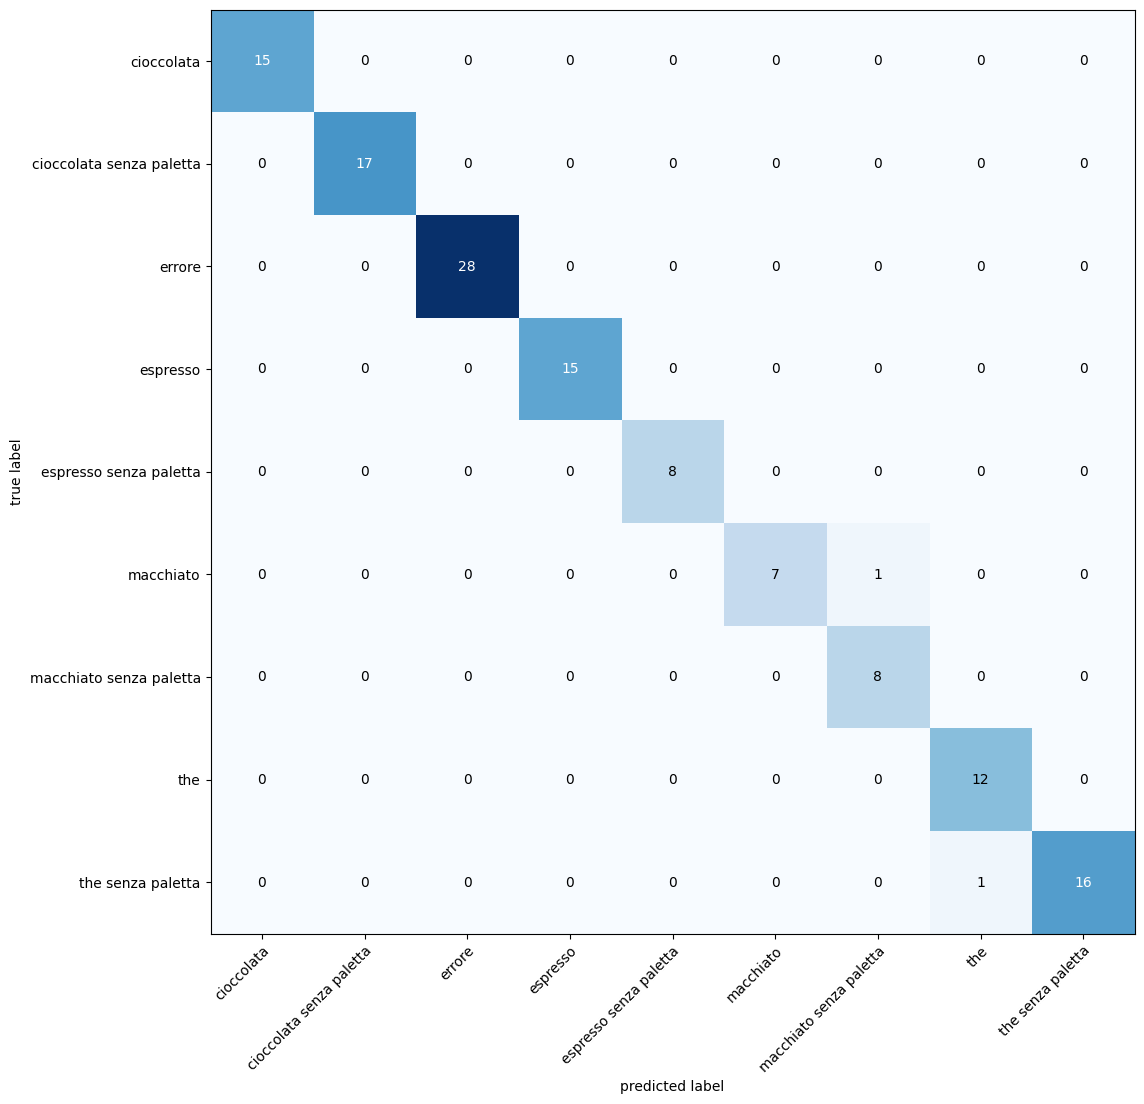

In [ ]:
interpreter = tf.lite.Interpreter(model_path='saved_lite_models/' + QUANTIZED_MODEL_NAME + '.tflite')
interpreter.allocate_tensors()

quantized_accuracy = evaluate_lite_model(interpreter, validation_dataset, class_names=class_names, show_confusion_matrix=True)
print("Accuracy of compressed model model: %.2f" %(quantized_accuracy*100) , '%')

In [ ]:
print("Pruned model size: ", get_zipped_model_size('saved_models/' + PRUNED_MODEL_NAME + '.keras')/10**6, ' MB')
print("Quantized model size: ", get_zipped_model_size('saved_lite_models/' + QUANTIZED_MODEL_NAME + '.tflite')/10**3, ' kB')

Pruned model size:  0.541202  MB
Quantized model size:  189.103  kB


## **Check for size and compression**

In [ ]:
print("Original model size: ", get_zipped_model_size('saved_models/' + MODEL_NAME + '.keras')/10**6, ' MB')
print("Pruned model size: ", get_zipped_model_size('saved_models/' + PRUNED_MODEL_NAME + '.keras')/10**6, ' MB')
print("Quantized model size: ", get_zipped_model_size('saved_lite_models/' + QUANTIZED_MODEL_NAME + '.tflite')/10**3, ' kB')

Original model size:  1.965329  MB
Pruned model size:  0.541202  MB
Quantized model size:  189.103  kB


## **Test compressed model**

In [ ]:
print('Accuracy: '          ,round(baseline_accuracy*100, 3), '%')
print('Pruned accuracy: '   ,round(100* pruned_accuracy,3) ,   '%')
print("Accuracy of compressed model model: %.2f" %(quantized_accuracy*100) , '%')

Accuracy:  97.656 %
Pruned accuracy:  98.438 %
Accuracy of compressed model model: 98.44 %
